In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
%load_ext autoreload
%autoreload 2

## Download

## List of files and end times

TODO: update these

In [3]:
# list of Rm files we process as (R,t0,t1,2) tuple
Rms=[
    ('5e2',50,4000,-1,4.97013),
    #('1e3',50,1200,-1,9.940268924035474),
    #('2e3',50,1000,-1),
    #('3e3',50,1000,-1),
    #('4e3',50,1000,-1),
    ('5e3',50,1000,-1,49.70134462017736),
    #('6e3',50,1000,-1),
    #('7e3',50,1000,-1),
    #('8e3',50,1000,-1),
    #('9e3',50,1000,-1),
    #('1e4',50,1200,-1),
    ('15e3',50,1500,-1,149.09657903158052),
]

## Visualization

Let's visualize the files we process so we can get the pick the limits for `t1` and `t2`.

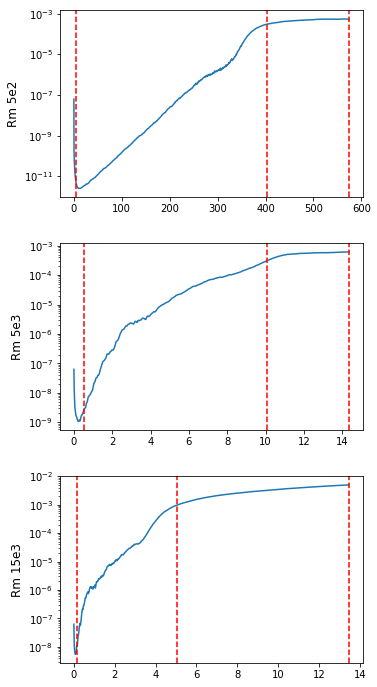

In [4]:
fig, axs = plt.subplots(nrows=len(Rms), figsize=(6,12), sharex=False)
plt.subplots_adjust(left=0.2, hspace=0.25)

for i,ax in enumerate(axs):
    Rm, t0,t1, t2, tres = Rms[i]
    tres *= 2.0 #XXX: why do we need this?
    mf = np.load('mfields_R'+Rm+'.npz')
    
    b2 = np.mean(np.array(mf['bxm'])**2, axis=1) + np.mean(np.array(mf['bym'])**2, axis=1)
    tarr = np.arange(len(b2))/tres
    ax.plot(tarr,b2)
    
    #pick last value if t = -1
    t2 = len(mf['bxm']) if t2 == -1 else t2 
    
    ax.axvline(t0/tres,color='r',linestyle='dashed')
    ax.axvline(t1/tres,color='r',linestyle='dashed')
    ax.axvline(t2/tres,color='r',linestyle='dashed')
        
    ax.set_yscale('log')
    #ax.set_title(r'Rm '+Rm,fontsize=14)
    ax.set_ylabel(r'Rm '+Rm,fontsize=12)

# Generic minimization with Nelder-Mead to get initial values


In [5]:
# initial setup
from scipy.optimize import minimize


useLog = False # flag if we use log fit
pinit = [0.02, 0.15] # reasonable initial guess
if useLog:
    pinit = np.log10(pinit)

In [27]:
# generic data container 
#FIXME: not used

class Data:
    def __init__(self, mf, conf, axis=0):
        self.t0 = conf['t0']
        self.t1 = conf['t1']

        self.tt   = mf['tt'][   self.t0 : self.t1]
        self.b2t  = mf['b2tot'][self.t0 : self.t1,:]
        self.bxm  = mf['bxm'][  self.t0 : self.t1,:]
        self.bym  = mf['bym'][  self.t0 : self.t1,:]
        self.emfx = mf['emfx'][ self.t0 : self.t1,:]
        self.emfy = mf['emfy'][ self.t0 : self.t1,:]

        # z-mode (time averaged)
        if axis == 0:
            nt, nz = np.shape(mf['emfx'])
            self.zz = np.linspace(0.0, 2.0*np.pi, nz)
            self.tt = self.zz


## Residuals

Residuals as a function of $t$ or $z$ are computed as a sum of two penalty functions that penalize the fit from the top and bottom as

 $ \mathcal{R} = | \frac{\epsilon_{R}}{\epsilon_{T}} + \frac{\epsilon_{T}}{\epsilon_{R}} -2| $,
 
 where $\epsilon_{R}$ is the reconstructed EMF and $\epsilon_{T}$ is the true EMF.

In [6]:
# compute residuals from true and reconstructed EMF
def residuals(emf2T, emf2R, axis=0):
    eR = np.sum(emf2R, axis=axis)
    eT = np.sum(emf2T, axis=axis)
    #sT = np.std(emf2T, axis=1)
    resd = np.abs(eR/eT + eT/eR - 2.0)

    return resd

## Model definition

### Linear
$\epsilon_x = \alpha B_x$

$\epsilon_y = \alpha B_y$

### Quadratic with quenching term
$\epsilon_x = \alpha \frac{ B_x$ }{1 + B^2/B_{Eq}^2} $

$\epsilon_y = \alpha \frac{ B_y$ }{1 + B^2/B_{Eq}^2} $

In [7]:
# Isotropic residual function 
def model(x):
    def emf2(x, y):
        return x*x + y*y

    if useLog:
        alpha_00 = 10.0**x[0]
        emf0     = 0.0
        beq      = 10.0**x[1]
    else:
        alpha_00 = x[0]
        emf0     = 0.0
        beq      = x[1]

    bxm  = df['Bx']
    bym  = df['By']
    b2t  = df['Bx']**2 + df['By']**2
        
    #first order alpha
    #emfxR = alpha_00*bxm + emf0
    #emfyR = alpha_00*bym + emf0

    #second order alpha
    alpha = alpha_00/(1.0 + b2t/beq**2.0)
    emfxR = alpha*bxm + emf0
    emfyR = alpha*bym + emf0
    
    return emfxR, emfyR

In [8]:
# actual fitting that transforms model into residual
def fit(x):
    def emf2(x, y):
        return x*x + y*y

    emfx = df['Ex'] 
    emfy = df['Ey']
    emf2T = emf2(emfx, emfy)   #TRUE EMF mfield
    
    emfxR, emfyR = model(x)
    emf2R = emf2(emfxR, emfyR) #reconstructed field
    
    # actual residuals are calculated here
    resd = residuals(emf2T, emf2R, axis=0)
    
    return resd

## Anisotropic version 

Here we have, in addition to the previous, anisotropic $\alpha$ that is now a matrix $\alpha_{ij}$.

The quadratic model is then

$ \epsilon_x = \frac{\alpha_{xx} B_x + \alpha_{xy} B_y}{1 + B^2/B_{eq}^2} $

$ \epsilon_y = \frac{\alpha_{yx} B_x + \alpha_{yy} B_y}{1 + B^2/B_{eq}^2} $

Evaluate this function instead if you want to enable the anisotropic fitting mode.

In [53]:
# Residual function 
def model(x):
    def emf2(x, y):
        return x*x + y*y

    if useLog:
        alpha_00 = 10.0**x[0]
        alpha_10 = 10.0**x[1]
        alpha_01 = 10.0**x[2]
        alpha_11 = 10.0**x[3]
        emf0     = 0.0
        beq      = 10.0**x[4]
    else:
        alpha_00 = x[0]
        alpha_10 = x[1]
        alpha_01 = x[2]
        alpha_11 = x[3]
        emf0     = 0.0
        beq      = x[4]

    bxm  = df['Bx']
    bym  = df['By']
    b2t  = df['Bx']**2 + df['By']**2

    #isotropic alpha 
    emfxR = alpha_00*bxm + emf0
    emfyR = alpha_00*bym + emf0
    
    #anisotropic alpha
    #emfxR = alpha_00*bxm + alpha_01*bym + emf0
    #emfyR = alpha_10*bxm + alpha_11*bym + emf0

    # second order alpha
    #norm = 1.0/(1.0 + b2t/beq**2.0)
    #emfxR *= norm
    #emfyR *= norm
    
    return emfxR, emfyR

## Likelihood

As a likelihood, we just sum over the residuals and take log as

$ \mathcal{L} = \log \sum_{t/z} |\mathcal{R_{t/z}}| $

In [9]:
#collapse residuals into likelihood
def lhood(x):
    return np.log(np.sum( np.abs(fit(x)) ))


## Nelder-Mead aka Amoeba fit


mfields_R5e2.npz
Generating z averaged dataframe with z1: 0 and z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:563: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


[0.2748577  0.50879843]

mfields_R5e3.npz
Generating z averaged dataframe with z1: 0 and z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
[1.06563018 1.62623547]

mfields_R15e3.npz
Generating z averaged dataframe with z1: 0 and z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
[0.12030109 0.27911362]


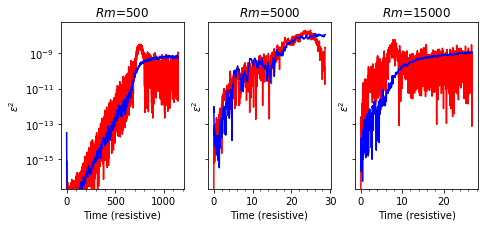

In [10]:
#visualize the fit
fig, axs = plt.subplots(ncols=len(Rms), figsize=(6.974,3), sharey=True)
#plt.subplots_adjust(left=0.2, hspace=0.25)

def nelder_mead(df):
    res = minimize(lhood, 
                   pinit,
                   method='Nelder-Mead',
                   tol=1.0e-4
                   )
    print(res.x)
    return res

for i in range(len(Rms)):
    fname,t0,t1,t2,tres = Rms[i]
    
    fname_full_path = 'mfields_R'+fname+'.npz'
    print()
    print(fname_full_path)
    
    #df = gen_df_tave(fname=fname_full_path, t1=t1, t2=t2,verbose=1)
    df = gen_df_zave(fname=fname_full_path, z1=0, z2=-1, verbose=1)
    res = nelder_mead(df)
    
    #plot amoeba results
    ax = axs[i]
    ax.minorticks_on()
    ax.set_xlabel(r'Time (resistive)')
    ax.set_yscale('log')            
    ax.set_ylabel(r'$\varepsilon^2$')

    #True field for comparison
    emf2  = df['Ex']**2 + df['Ey']**2
    tarr = np.arange(len(emf2))/tres
    ax.plot(tarr, emf2, 'r-', label=r'<\varepsilon$^2$>')

    #reconstruction
    exF, eyF = model(res.x)
    emf2F = exF*exF + eyF*eyF
    ax.plot(tarr, emf2F, 'b-', label=r'fit $\alpha_0$')

    #legends
    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles, labels, fontsize=10, loc=4, frameon=False)
    
    ax.set_title(r"$Rm$="+str(np.int(float(Rms[i][0]))))

    
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.98, top=0.92)
plt.savefig("mcmc_data.pdf")

## MCMC

First, Amoeba is run (again) and the best-fit is used as a starting guess for the MCMC chain.

This needs to be run only once, if you have already ran this and produced the chain file, you can just skip to the next section where results are visualized.

In [15]:
#collapse residuals into likelihood;
#this is basically same as lhood() function but we just clean the results
#by imposing sharp priors for unphysical results.

def sanity_check(x):
    if useLog:
        for xi in x:
            if xi < -4.0 or xi > 2.0:
                return False
    else:
        for xi in x:
            if xi < 0.0 or xi > 2.0:
                return False
    return True

linf = np.inf
def lprob(x):
    if not(sanity_check(x)):
        return -linf

    lp = lhood(x)
    return -lp


In [12]:
import emcee 

isotrop = True #flag to pick iso/anisotropic mode; 
                #remember to load correct function too!

In [16]:
for i in range(len(Rms)):
    fname,t0,t1,t2,tres = Rms[i]

    fname_full_path = 'mfields_R'+fname+'.npz'
    print()
    print(fname_full_path)
    
    #df = gen_df_tave(fname=fname_full_path, t1=t1, t2=t2,verbose=1)
    df = gen_df_zave(fname=fname_full_path, z1=0, z2=-1, verbose=1)
    res = nelder_mead(df)
    
    #initialization
    if isotrop:
        pinit = res.x #initial guess from non-linear fit
    else:
        pinit = np.zeros(5)
        pinit[0] = res.x[0] #xx
        pinit[1] = 0.0      #xy
        pinit[2] = 0.0      #yx
        pinit[3] = res.x[0] #yy
        pinit[4] = res.x[1] #b
    print(pinit)
    
    # number of walkers is roughly 3*number of parameters
    nwalkers = 15
    ndim = len(pinit)
    
    #initialize small Gaussian ball around the initial point
    p0 = [pinit + 1.0e-4*np.random.rand(ndim) for i in range(nwalkers)]
    
    #output
    if isotrop:
        filename = "chain_0_Rm" + str(fname)+".h5"
    else:
        filename = "chain_0_ani_Rm" + str(fname)+".h5"

    backend = emcee.backends.HDFBackend(filename)
    print(nwalkers)
    print(ndim)
    backend.reset(nwalkers, ndim) #no restart
            
    # initialize sampler
    sampler = emcee.EnsembleSampler(
                nwalkers, 
                ndim, 
                lprob, 
                backend=backend, 
                )
    
    #and finally, run it until ~5000 steps
    result = sampler.run_mcmc(p0, 5000, progress=True)


mfields_R5e2.npz
Generating z averaged dataframe with z1: 0 and z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
  0%|          | 3/5000 [00:00<02:55, 28.42it/s]

[0.27485769 0.97028232]
[0.27485769 0.97028232]
15
2


100%|██████████| 5000/5000 [02:39<00:00, 31.32it/s]



mfields_R5e3.npz
Generating z averaged dataframe with z1: 0 and z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1


  0%|          | 4/5000 [00:00<02:30, 33.09it/s]

[1.0656302  1.59661897]
[1.0656302  1.59661897]
15
2


100%|██████████| 5000/5000 [02:33<00:00, 32.61it/s]



mfields_R15e3.npz
Generating z averaged dataframe with z1: 0 and z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1


  0%|          | 4/5000 [00:00<02:23, 34.76it/s]

[0.12030101 1.97123105]
[0.12030101 1.97123105]
15
2


100%|██████████| 5000/5000 [02:12<00:00, 34.43it/s]


## Visualize MCMC chains

First, the chains need to be processed. We skip the burn-in (when walkers are just warming up) and thin the chain (to avoid autocorrelation of values).

There are various ways we can check the sanity of MCMC chains. Here we employ the most usual tricks and produce:

- trace (i.e., fit parameter values as a function of walker steps)
- triangle (plot covariance of all parameters against each other)
- draw samples from the chain and visualize the reconstructed model

chain_0_Rm5e2.h5
burn-in: 100
thin: 1
flat chain shape: (73500, 2)
flat log prob shape: (73500,)
(73500, 2)
['$\\alpha$', '$B_{eq}$']
triangle
trace
model

../mfields_R5e2.npz
Generating z averaged dataframe with z1: 0 and z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
plotting 3675 samples


/usr/local/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


chain_0_Rm5e3.h5
burn-in: 100
thin: 1
flat chain shape: (73500, 2)
flat log prob shape: (73500,)
(73500, 2)
['$\\alpha$', '$B_{eq}$']
triangle
trace
model

../mfields_R5e3.npz
Generating z averaged dataframe with z1: 0 and z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
z1: 0, z2: -1
plotting 3675 samples


chain_0_Rm15e3.h5
burn-in: 100
thin: 1
flat chain shape: (73500, 2)
flat log prob shape: (73500,)
(73500, 2)
['$\\alpha$', '$B_{eq}$']
triangle
trace
model

../mfields_R15e3.npz
Generating z averaged dataframe with z1: 0 and z2: -1


FileNotFoundError: [Errno 2] No such file or directory: '../mfields_R15e3.npz'

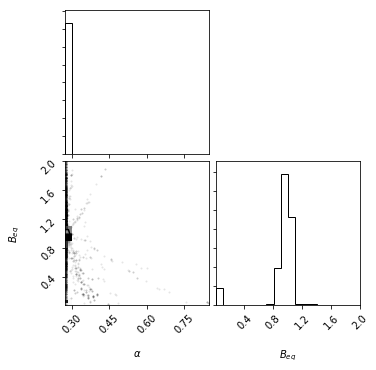

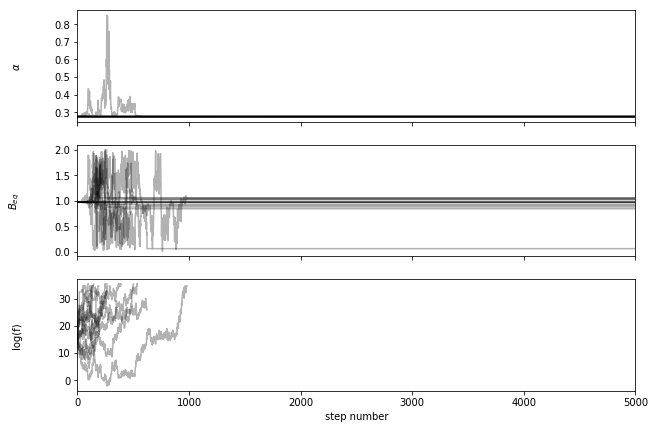

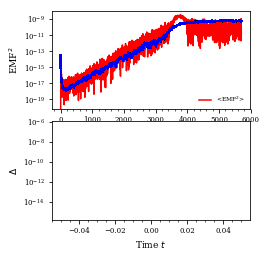

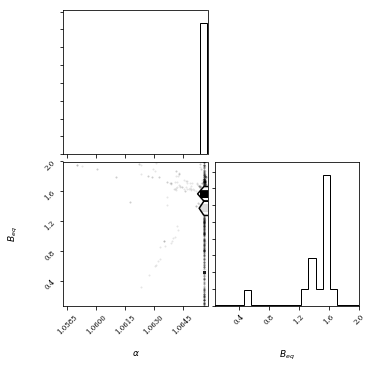

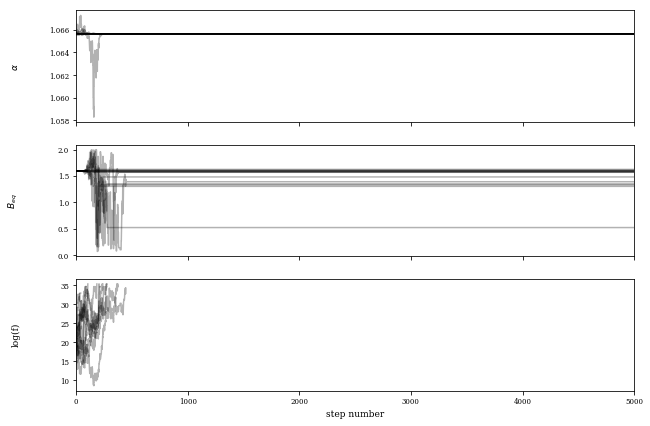

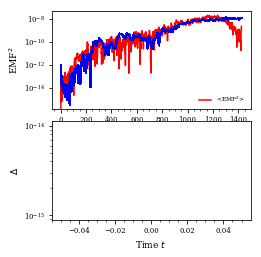

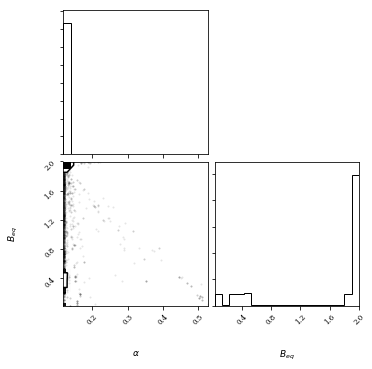

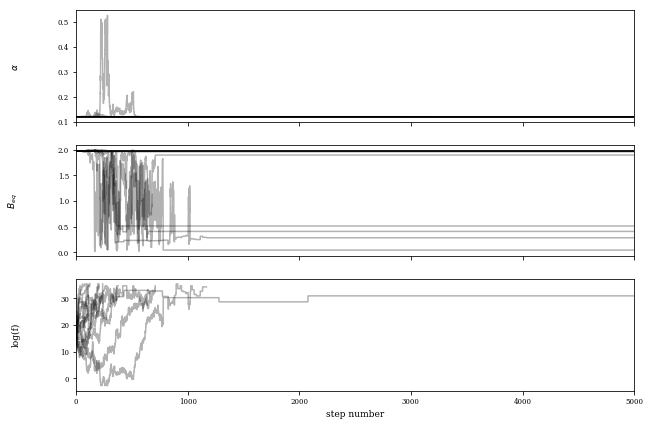

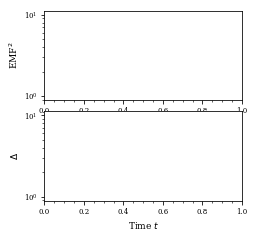

In [17]:
import corner

burnin = 100
thin = 1

for i in range(len(Rms)):
    fname,t0,t1,t2,tres = Rms[i]
    
    if isotrop:
        filename = 'chain_0_Rm' + str(fname) + '.h5'
    else:
        filename = 'chain_0_ani_Rm' + str(fname) + '.h5'
    print(filename)
    reader = emcee.backends.HDFBackend(filename)

    # estimate autocorrelation time (can be used for the thinning)
    #tau = reader.get_autocorr_time()
    #print("autocorr time: {}".format(tau))

    samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
    log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
    #blob_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

    print("burn-in: {0}".format(burnin))
    print("thin: {0}".format(thin))
    print("flat chain shape: {0}".format(samples.shape))
    print("flat log prob shape: {0}".format(log_prob_samples.shape))
    #print("flat blob shape: {0}".format(blob_samples.shape))

    all_samples = samples
    print(np.shape(all_samples))
    if isotrop:
        labels = [r"$\alpha$", r"$B_{eq}$"]
    else:
        labels = [
          r"$\alpha_{xx}$", 
          r"$\alpha_{xy}$", 
          r"$\alpha_{yx}$", 
          r"$\alpha_{yy}$", 
          r"$B_{eq}$"]

    ndim = len(labels)
    print(labels)
    ##################################################
    # triangle/corner plot

    if True:
        print("triangle")
        fig = corner.corner(all_samples, 
            #quantiles=[0.16, 0.5, 0.84],
            #show_titles=True, 
            #title_kwargs={"fontsize": 12})
            labels=labels)
    
        plt.savefig("triangle_"+ str(fname)+".pdf")

    ##################################################
    # trace plot
    if True:
        print("trace")

        fig, axes = plt.subplots(ndim+1, figsize=(10, 7), sharex=True)
        samples = reader.get_chain()
        log_prob_samples = reader.get_log_prob()

        labels.append("log(f)")

        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)

        #log prob
        i = ndim
        ax = axes[i]
        ax.plot(log_prob_samples[:, :], "k", alpha=0.3)
        ax.set_xlim(0, len(log_prob_samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number");
        plt.savefig("trace_0_"+ str(fname)+".pdf")
        
    ###################################################
    # model vs data
    if True:
        print("model")
    
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize=7)
        plt.rc('ytick', labelsize=7)
        plt.rc('axes', labelsize=9)
        
        fig = plt.figure(figsize=(3.54, 3.5)) #single column fig
        #fig = plt.figure(figsize=(7.48, 4.0))  #two column figure
        gs = plt.GridSpec(2, 1, hspace=0.12)
        
        axs = []
        axs.append( plt.subplot(gs[0,0]) )
        axs.append( plt.subplot(gs[1,0]) )
        
        for ax in axs:
            ax.minorticks_on()
            ax.set_xlabel(r'Time $t$')
            #ax.set_xlim((0.0, 1000.0))
        axs[0].set_yscale('log')
        axs[1].set_yscale('log')
        
        axs[0].set_ylabel('EMF$^2$')
        axs[1].set_ylabel('$\Delta$')
    
        # read arrays
        fname_full_path = '../mfields_R'+fname+'.npz'
        print()
        print(fname_full_path)
    
        #df = gen_df_tave(fname=fname_full_path, t1=t1, t2=t2,verbose=1)
        df = gen_df_zave(fname=fname_full_path, z1=0, z2=-1, verbose=1)

        #True field for comparison
        emf2  = df['Ex']**2 + df['Ey']**2
        axs[0].plot(emf2, 'r-', label=r'<EMF$^2$>')

        #samples drawn from posteriors
        samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
        niter, nparam = samples.shape
        
        print("plotting {} samples".format(len(range(0,niter,20))))
        for ix in range(0, niter, 20):
            p0 = samples[ix,:ndim]

            #reconstruction
            exF, eyF = model(p0)
            emf2F = exF*exF + eyF*eyF
            axs[0].plot(emf2F, 'b-', alpha=0.2)

            # residuals
            resd = fit(p0)
            axs[1].plot(resd, 'g-', alpha=0.2)

        #legends
        handles, labels = axs[0].get_legend_handles_labels()
        axs[0].legend(handles, labels, fontsize=6, loc=4, frameon=False)
    
        #axs[0].set_ylim((1.0e-12, 1.0e-7))
    
        plt.subplots_adjust(left=0.2, bottom=0.12, right=0.98, top=0.95, wspace=0.0, hspace=0.0)
        plt.savefig('data_Rm_0_' + str(fname) + '.pdf')


